#### CSCA 5642 Introduction to Deep Learning
# Natural Language Processing with Disaster Tweets

***

## Brief Description of the Problem and Data (5 pts)

The challenge is to **detect whether a tweet is about a real disaster or not**. This task is crucial in disaster response management, as accurately identifying relevant information can significantly enhance crisis response efforts. To tackle this challenge, a Natural Language Processing (NLP) model will be employed due to its effectiveness in text analysis and understanding.

The data is sourced from the [Natural Language Processing with Disaster Tweets Dataset](https://www.kaggle.com/c/nlp-getting-started/data), which **includes both training and test sets**. The training set comprises **7,613 tweets**, each labeled as disaster ('1') or non-disaster ('0'). These tweets are presented in plain text format and represent a wide range of contexts and wording variations. The test set consists of unlabeled tweets that will be used to evaluate the model's performance.

***
## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In the EDA step, we will check the dataset, perform cleaning procedures, and draw a few visualizations such as a Text Length Histogram and label distributions. Finally, we will discuss the plan for analysis.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-07-28 13:12:56.010764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 13:12:56.010857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 13:12:56.178020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
import keras

In [4]:
import keras_nlp
print(keras_nlp.__version__)

0.14.0


Let's first check the dataset and explore them.

In [5]:
root_folder = '/kaggle/input/nlp-getting-started'
print(os.listdir(root_folder))

['sample_submission.csv', 'train.csv', 'test.csv']


In [6]:
df_train = pd.read_csv(f"{root_folder}/train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_test = pd.read_csv(f"{root_folder}/test.csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
df_train["keyword"].value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [10]:
df_train["location"].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64

It looks like some of the `keyword` and `location` values may be missing. However, since we are not planning to use `location` and `keyword` as features in our NLP model, we will ignore these columns entirely. Therefore, cleaning them is unnecessary.

And **for handling stopwords, since we are using contextual models like DistilBERT and RoBERTa that provide context to the user's intent, we will keep the stopwords instead of removing them, as they offer sufficient context information.**

In [11]:
df_train = df_train[['text', 'target']]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


Now, let's examine the distribution of text length and the labels.

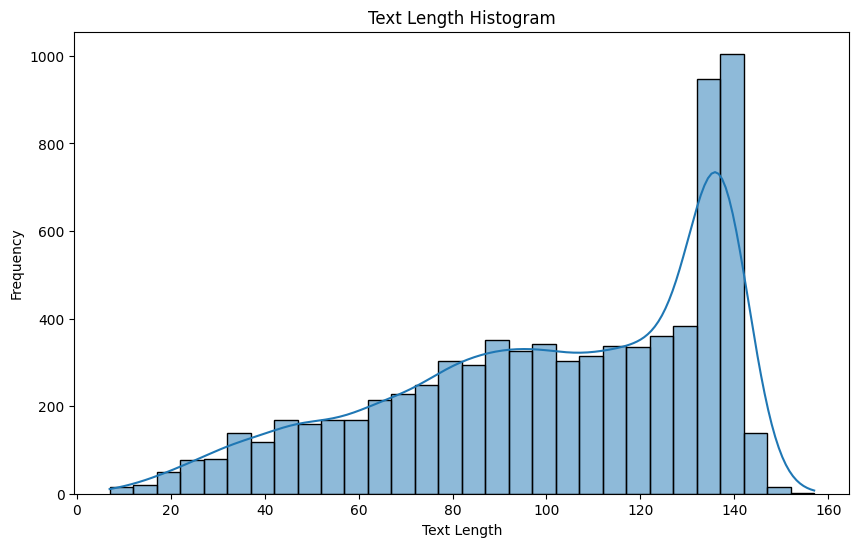

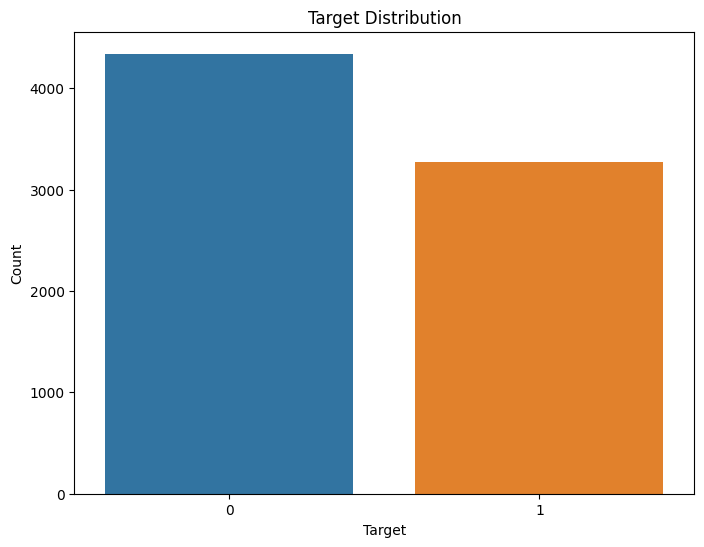

In [12]:
# Suppress the specific warning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Compute text length
df_train['text_length'] = df_train['text'].apply(len)

# 1. Text Length Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30, kde=True)
plt.title('Text Length Histogram')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 2. Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_train)
plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


The first plot, the text length histogram, reveals the distribution of text lengths within the dataset. The histogram indicates that the text lengths vary widely, with a noticeable peak around 140 characters, suggesting that a significant portion of the texts are close to this length. This distribution is slightly right-skewed, indicating that there are some texts with lengths significantly shorter than the peak, but few texts longer than 140 characters.

The second plot, the target distribution, shows the count of the target variable, which has binary values of 0 and 1. The plot reveals that there are more instances with a target value of 0 compared to 1, indicating an imbalance in the dataset. Specifically, there are approximately 4000 instances with a target of 0 and about 3600 instances with a target of 1. This imbalance might be important to consider when building and evaluating predictive models, as it could affect the performance and the metrics used to measure model accuracy.

# Plan of analysis
Based on our exploratory data analysis, the plan for analysis includes:

- **Data Preparation**: Use the provided dataset and split it into training and validation sets.
- **Model Building**: Construct two models using Keras NLP - one with DistilBERT and another with RoBERTa for text classification.
- **Hyperparameter Tuning**: Utilize keras_tuner to find the optimal hyperparameters for each model.
- **Model Training**: Train both models using the best hyperparameters found through tuning.
- **Evaluation**: Evaluate the performance of both models on the validation set.

By following this plan, we aim to build robust models capable of accurately classifying text data.

# Model Architecture (25 pts)

We are going to load **two pretrained models, DistilBERT and RoBERTa**, both of which follow a transformer architecture for natural language processing tasks. BERT has proven to be effective in handling NLP tasks.

**Model's architecture**:

**1. DistilBERT**

- Embedding Layer:
Converts input tokens into dense vectors that capture the meaning of the words.

- Transformer Layers:
Comprises 6 layers of transformers (half of BERT's 12 layers).
Each layer has self-attention mechanisms to understand the context of each word relative to others in the sentence.
Positional embeddings are added to capture the order of words.

- Classification Head:
A feed-forward neural network layer that takes the final transformer outputs and predicts the class label for the input text.

**2. RoBERTa**
- Embedding Layer:
Converts input tokens into dense vectors similar to DistilBERT.

- Transformer Layers:
Comprises 12 layers of transformers, similar to BERT but with optimizations.
Enhanced self-attention mechanisms and layer normalization to better capture the context and relationships between words.
Trained with dynamic masking and larger datasets.

- Classification Head:
Similar to DistilBERT, a feed-forward neural network layer that predicts the class label for the input text.

**Reasoning for Using these Architectures**

- Pretrained Models:

These models are pretrained on large corpora, allowing them to understand and process text effectively even with smaller task-specific datasets. This pretraining provides a solid foundation for various NLP tasks.

- Efficiency and Performance:

DistilBERT offers a good balance between efficiency and performance. It is faster and smaller, making it suitable for applications where computational resources are limited.
RoBERTa, with its robust training and optimizations, provides enhanced performance and accuracy, making it suitable for scenarios where achieving the highest accuracy is critical.

- Flexibility:

Both models are designed to be fine-tuned for specific tasks, such as text classification. Fine-tuning adjusts the pretrained models to the nuances of the specific dataset and task, improving their performance.

***
First, let's split the training and validation data using scikit-learn.

In [13]:
from sklearn.model_selection import train_test_split

X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")

Number of training samples: 6090
Number of validation samples: 1523


## Model 1 - DistilBert

The first pretrained model we are going to use is **DistilBert**.

DistilBERT is a smaller, faster, and cheaper version of the BERT (Bidirectional Encoder Representations from Transformers) model. It retains 97% of BERT's language understanding capabilities while being 60% faster and having 40% fewer parameters.

***How it works:***

It reads text and understands the context of words in sentences. For example, it knows that "bank" can mean a financial institution or the side of a river based on surrounding words. It learns from vast amounts of text data to predict missing words in sentences, which helps it understand language patterns.

The code below defines a hypermodel for tuning a DistilBERT-based classifier. It begins by importing keras_tuner for hyperparameter tuning and keras_nlp for utilizing NLP models. The DistilBertHyperModel class is defined to facilitate hyperparameter tuning for a DistilBERT-based model. The build method within this class initializes the DistilBertPreprocessor and DistilBertClassifier from preset configurations. A hyperparameter for the learning rate is defined within a specified range. The model is then compiled with the Adam optimizer and Sparse Categorical Crossentropy loss.

In [20]:
import keras_tuner as kt
# Define HyperModel for DistilBERT
class DistilBertHyperModel(kt.HyperModel):
    def build(self, hp):
        preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
            "distil_bert_base_en_uncased"
        )
        model = keras_nlp.models.DistilBertClassifier.from_preset(
            "distil_bert_base_en_uncased",
            preprocessor=preprocessor,
            num_classes=2
        )

        # Hyperparameters
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=9e-5)
        optimizer = keras.optimizers.Adam(learning_rate)

        model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=optimizer,
            metrics=["accuracy"]
        )
        return model

## Model 2 - RoBERTa

The second pretrained model we are going to use is **RoBERTa**.

RoBERTa (Robustly optimized BERT approach) is an optimized version of BERT. It improves BERT by training with more data, longer training times, and removing some of BERT's training constraints.

***How it works:***

Like BERT, RoBERTa reads and understands the context of words in sentences. It uses a transformer architecture to do this, paying attention to all words in a sentence to grasp their meanings. RoBERTa can be fine-tuned for various tasks, like text classification, where it learns to categorize text based on the training it receives.


In [21]:
# Define HyperModel for RoBERTa
class RobertaHyperModel(kt.HyperModel):
    def build(self, hp):
        preprocessor = keras_nlp.models.RobertaPreprocessor.from_preset(
            "roberta_base_en"
        )
        model = keras_nlp.models.RobertaClassifier.from_preset(
            "roberta_base_en",
            preprocessor=preprocessor,
            num_classes=2
        )

        # Hyperparameters
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=9e-5)
        optimizer = keras.optimizers.Adam(learning_rate)

        model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=optimizer,
            metrics=["accuracy"]
        )
        return model

## Hyperparameter Tuning and Model Training

The following code performs hyperparameter tuning for two models: DistilBERT and RoBERTa. The tuning process is conducted using `keras_tuner` to optimize the `val_accuracy`. The best models are then trained, and their weights are saved.

### Initializing the Tuner

The `kt.RandomSearch` tuner is used to search for the best hyperparameters for both DistilBERT and RoBERTa models.

### Callbacks
The `ModelCheckpoint` and `EarlyStopping` callbacks are defined to monitor the validation accuracy and save the best model weights. Early stopping helps to avoid overfitting by stopping training when no improvement is observed.


In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initialize the tuner
distilbert_tuner = kt.RandomSearch(
    DistilBertHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='distilbert_tuning',
    project_name='distilbert'
)

roberta_tuner = kt.RandomSearch(
    RobertaHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='roberta_tuning',
    project_name='roberta'
)

# Define the ModelCheckpoint callback
checkpoint1 = ModelCheckpoint(
    'best_distilbert_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping1 = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=1,  # Number of epochs to wait before stopping when no improvement
    mode='max',  # We want to maximize the validation accuracy
    verbose=1  # Print a message when stopping
)

checkpoint2 = ModelCheckpoint(
    'best_roberta_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping2 = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=1,  # Number of epochs to wait before stopping when no improvement
    mode='max',  # We want to maximize the validation accuracy
    verbose=1  # Print a message when stopping
)

Reloading Tuner from distilbert_tuning/distilbert/tuner0.json
Attaching 'model.safetensors' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/merges.txt' from model 'keras/robe

### Running the Hyperparameter Search
The hyperparameter search is conducted for both models using the defined callbacks.

### Getting the Best Hyperparameters and Models
The best hyperparameters found during the search are used to build the models. The best weights are then loaded into the models.

In [17]:
# Run the hyperparameter search for distilbert
distilbert_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    callbacks=[checkpoint1, early_stopping1],
    verbose=1
)

Trial 2 Complete [00h 06m 45s]
val_accuracy: 0.8345370888710022

Best val_accuracy So Far: 0.8437294960021973
Total elapsed time: 00h 13m 48s


In [18]:
# Get the best hyperparameters for each model
best_distilbert_hps = distilbert_tuner.get_best_hyperparameters()[0]
print("Best hyperparameters for DistilBERT:", best_distilbert_hps.values)

# Build the models using the best hyperparameters
best_distilbert_model = distilbert_tuner.hypermodel.build(best_distilbert_hps)

# Load the best weights
best_distilbert_model.load_weights('best_distilbert_model.keras')

Best hyperparameters for DistilBERT: {'learning_rate': 1e-05}
Attaching 'model.safetensors' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert

In [4]:
import shutil
shutil.rmtree("./roberta_tuning")

In [23]:
# Run the hyperparameter search for roberta
roberta_tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    callbacks=[checkpoint2, early_stopping2],
    verbose=1,
    batch_size=16
)

Trial 2 Complete [00h 13m 18s]
val_accuracy: 0.5738673806190491

Best val_accuracy So Far: 0.8463558554649353
Total elapsed time: 00h 26m 51s


In [24]:
# Get the best hyperparameters for each model
best_roberta_hps = roberta_tuner.get_best_hyperparameters()[0]
print("Best hyperparameters for RoBERTa:", best_roberta_hps.values)

# Build the models using the best hyperparameters
best_roberta_model = roberta_tuner.hypermodel.build(best_roberta_hps)

# Load the best weights
best_roberta_model.load_weights('best_roberta_model.keras')

Best hyperparameters for RoBERTa: {'learning_rate': 1e-05}
Attaching 'model.safetensors' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/merges.txt' from model 'keras/roberta

### Model Training and Evaluation
After determining the best hyperparameters through the hyperparameter search, the models were trained using these optimal settings to capture their training history. This process enabled detailed analysis of the models' performance across epochs. The best-performing model identified was the `RoBERTa model` which utilized a learning rate of `1e-5`. Following training, the models were evaluated on the validation set to assess their performance, confirming the superiority of the RoBERTa model with the specified learning rate.

Next, we will retrain the best model with the best hyperparameter, visualize the results, and predict the test dataset.

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

roberta_processor = keras_nlp.models.RobertaPreprocessor.from_preset(
    "roberta_base_en"
)

roberta_model = keras_nlp.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    preprocessor=roberta_processor,
    num_classes=2
)

loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(learning_rate)

roberta_model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"]
)

roberta_checkpoint = ModelCheckpoint(
    'best_roberta_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


# Start training and store the history
roberta_history = roberta_model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[roberta_checkpoint],
    verbose=True
)

# Load the best weights after training
roberta_model.load_weights('best_roberta_model.keras')

Attaching 'model.safetensors' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'model.safetensors.index.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.json' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/merges.txt' from model 'keras/roberta/keras/roberta_base_en/2' to your Kaggle notebook...
Attach

I0000 00:00:1722172520.819954     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722172520.895273     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


380/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7398 - loss: 0.5167

W0000 00:00:1722173142.232035     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7400 - loss: 0.5165

W0000 00:00:1722173151.894059     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.85161, saving model to best_roberta_model.keras


W0000 00:00:1722173197.923404     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


381/381 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.7401 - loss: 0.5163 - val_accuracy: 0.8516 - val_loss: 0.3756
Epoch 2/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8587 - loss: 0.3488
Epoch 2: val_accuracy did not improve from 0.85161
381/381 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.8587 - loss: 0.3488 - val_accuracy: 0.8444 - val_loss: 0.3739
Epoch 3/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8842 - loss: 0.2912
Epoch 3: val_accuracy did not improve from 0.85161
381/381 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.8842 - loss: 0.2912 - val_accuracy: 0.8240 - val_loss: 0.4289
Epoch 4/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9141 - loss: 0.2316
Epoch 4: val_accuracy did not improve from 0.85161
381/381 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9141 - loss: 0.2316 - val_accuracy: 0.8148 - val_loss: 0.5068
Epoch 5/5
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9263 - loss: 0.1884
Epoch 5: val_accuracy did not improve f

# Results and Analysis (35 pts)




### Plotting the Training History

To visualize the training process and performance of the model, we plot the training and validation accuracy and loss over the epochs for the selected RoBERTa model.

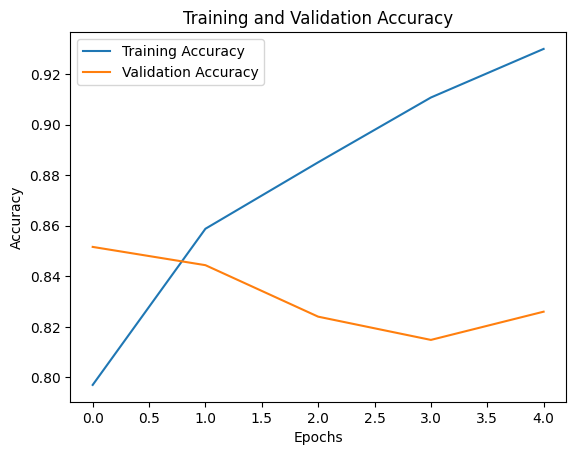

In [16]:
# Plot the results
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(roberta_history, 'RoBERTa')

The training/validation accuracy vs. epoch diagram shows that the model reached optimal performance roughly at the first epoch. This may be due to using a rather sophisticated model compared to the dataset, which is relatively small.

As mentioned previously, `RoBERTa` was selected as the base model because it performs better than `DistilBERT`, though the difference is not substantial. Also, the hyperparameter search shows that a smaller learning rate works better in this case.

During the training process, a batch size of 32 frequently caused `RoBERTa` training to exceed the memory limits of the kernel, corrupting it. We had to use a smaller batch size (16) to successfully complete the training of `RoBERTa`. This issue was challenging to debug because the notebook would sometimes clear the output and reset the kernel, leaving us without any clues. I've tried running the notebook in background mode to gather more logs to help identify the issue.

# Conclusion (15 pts)


## 1. Results Overview:

RoBERTa model outperformed DistilBERT model probably due larger model parameters, which allowed it to capture more complex patterns and features from the images.

## 2. Learnings and Takeaways:

- Training on a CPU was extremely inefficient and time-consuming, making it impractical for this assignment. Using a personal laptop proved to be insufficient for the computational demands of training these models.
- Utilizing platforms like Google Colab or Kaggle, which offer GPU resources, significantly improves training efficiency and reduces setup time.

## 3. Challenges:

Training on a CPU was nearly impossible to complete the assignment in a reasonable timeframe. Even with GPU resources, training the models took a considerable amount of time, leaving limited time for hyperparameter tuning and experimentation.

## 4. Future Improvements:

To improve the process, we could focus more on proper modeling selection and hyperparameter training. A sophiscated BERT model can inheritantly perform this task well, so more effort should be put into the hyperparameter tuning to futher increase the prediction score.

# Submission

In [17]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission["target"] = np.argmax(roberta_model.predict(df_test['text']), axis=1)
submission.to_csv("submission.csv", index=False)

  1/102 ━━━━━━━━━━━━━━━━━━━━ 12:18 7s/step

W0000 00:00:1722176166.363896     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 105s 964ms/step


W0000 00:00:1722176263.732501     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [18]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
